#### Introduction

**Summary:**

The following document analyzes building permits, customer service request complaints, and code enforcement cases in Los Angeles with the following questions in mind:

1. Have liberalized ADU policies in California affected ADU permitting and construction? 
2. Is reactive code enforcement likely to lead to disparate impact or outcomes based on demographic or socioeconomic factors? 

**Findings:**

The number of ADU permits issued has risen sharply over time since statewide measures aimed at increasing ADU usage were passed in 2016 and 2019. 

ADU permit issuance, and residential construciton in general, tends to be concentrated in wealthy, white neighborhoods. This suggests lower-income and more diverse neighborhoods are not receiving the economic & housing market benefits intended by recent ADU policy liberalization. 

Customer service requests, issued by citizens to the Department of Building and Safety, also tend to be concentrated in wealthy, white neighborhoods. While this may indicate that reactive code enforcement is likely to disproportionately focus on these enclaves, it is worth noting that there doesn't appear to be any substantial differences in complaints along demographic or economic features when controlling for the quantity of building permits in an area (given that areas with more construction are likely to have more complaints). 

**Limitations:** 

The data available on LA's open data portal does not make it easy to disaggregate ADU-related complaints from other types, so we cannot precisely answer whether ADU-related code enforcement is likely to be affected by bias.

Additionally, the city's code enforecement and complaint datasets do not have open text fieds, and the former lacks import details such as whether actual violations were found during an inspection. These fields would help to answer whether complaint-generated code enforecement cases mislead city officials differentially based on demographic & socioeconomic factors. 


In [459]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sodapy import Socrata
import censusdata as cd
import censusgeocode as cg
import math
from datetime import datetime
import geopandas as gpd
from geopandas.tools import sjoin
import re
import statsmodels.formula.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
import patchworklib as pw 
pd.options.mode.chained_assignment = None

### Part I. Import Data from LA Open Data Portal

In [460]:
# Function to get data via Socrata API
def import_la_data(dataset_id, query=False, limit=5000000):

    # Check if using query and import data from endpoint using dataset identifiers and save to dataframe
    if query == False:        
        Results = client.get(dataset_id, limit=limit, exclude_system_fields=True)        
    else:
        Results = client.get(dataset_id, where=query, limit=limit, exclude_system_fields=True)
    
    df = pd.DataFrame.from_records(Results)
    return df

# Set min date to use in queries
min_date='2015-01-01'
min_date_00 = '0015-01-01' # to account for datestamp issue in complaints and enforcement datasets

# Connect to SODA API Endpoint
client = Socrata('data.lacity.org', None, timeout=30)

# Import Permit data
df_bldg_permits_submitted = import_la_data(
                                dataset_id='ct5r-6sgd', 
                                query="submitted_date >= '" + min_date + "'"
                            ) # https://data.lacity.org/City-Infrastructure-Service-Requests/
                                    # Building-and-Safety-Permit-Submitted-from-2010-to-/ct5r-6sgd    

df_bldg_permits_issued = import_la_data(
                                dataset_id='n9nq-vewq', 
                                query="issue_date >= '" + min_date + "'"
                            ) # https://data.lacity.org/City-Infrastructure-Service-Requests/
                                    # Building-and-Safety-Permit-Issued-2010-to-now/n9nq-vewq

# Import Building and Safety Customer Service Request data
df_bldg_csr_complaints_open = import_la_data(
                                'bsvt-chkv', query="date_received >= '" + min_date_00 + "'"
                            ) # https://data.lacity.org/City-Infrastructure-Service-Requests/
                                    # Building-and-Safety-Customer-Service-Request/bsvt-chkv

df_bldg_csr_complaints_closed = import_la_data(
                                '8qjh-sbs9', query="date_received >= '" + min_date_00 + "'"
                            ) # https://data.lacity.org/City-Infrastructure-Service-Requests/
                                    # Building-and-Safety-Customer-Service-Request-Close/8qjh-sbs9

# Import Building and Safety Code Enforcement Cases data
df_bldg_code_enforcement_closed = import_la_data(
                                    'q3qu-98vb', query="date_case_gen >= '" + min_date_00 + "'"
                            ) # Closed https://data.lacity.org/City-Infrastructure-Service-Requests/
                                    # Building-and-Safety-Code-Enforcement-Case-Closed-/q3qu-98vb

df_bldg_code_enforcement_open = import_la_data(
                                    '2uz8-3tj3', query="date_case_generated >= '" + min_date_00 + "'"
                            ) # https://data.lacity.org/City-Infrastructure-Service-Requests/
                                    # Building-and-Safety-Code-Enforcement-Case/2uz8-3tj3

# Close connection
client.close()

# Import LA census blocks shapefile
df_la_shp = gpd.read_file(
    'Census_Blocks_2020/Census_Blocks_2020.shp'
) # https://geohub.lacity.org/datasets/lacounty::census-blocks-2020/about

df_la_shp_bg = gpd.read_file(
    'Census_Block_Groups_2020/Census_Block_Groups_2020.shp'
) # https://egis-lacounty.hub.arcgis.com/datasets/lacounty::census-block-groups-2020/about

### Part II. Clean and Prep LA Datasets

#### ii.a) Code Enforcement Data

In [461]:
# Rename columns so enforcement closed and opened can be concatenated
df_bldg_code_enforcement_open.rename(
    columns={
        'date_case_generated': 'date_case_gen',
        'ladbs_inspection_district':'ladbs_insp_dist',
        'address_house_number':'addr_hse_num',
        'address_street_direction':'addr_str_dir',
        'address_street_name':'addr_str_name',
        'address_street_suffix':'addr_str_suffix',
        'address_zip':'addr_zip',
        'gis_parcel_identification_number_pin':'pin',
        'area_planning_commission_apc':'apc',
        'address_house_fraction_number':'addr_hse_frac_num',
        'latitude_longitude':'lat_lon',
        'address_street_suffix_direction':'addr_str_suffix_dir'
        }, 
    inplace=True
    )
df_bldg_code_enforcement_open['date_case_closed'] = ''

# Get rid of fields containing word 'computed'
for df in [df_bldg_code_enforcement_closed, df_bldg_code_enforcement_closed]:
    df = df.loc[:,~df.columns.str.contains('computed')]
    
# Combine enforcement_closed and open datasets
df_bldg_code_enforcement_open = df_bldg_code_enforcement_open[df_bldg_code_enforcement_closed.columns]
df_bldg_code_enforcement = pd.concat(
                            [df_bldg_code_enforcement_closed, df_bldg_code_enforcement_open], ignore_index=True
                        )

# Fix date stamps which are stored incorrectly in LA data
for col in ['date_case_gen', 'date_case_closed']:
    df_bldg_code_enforcement[col] = df_bldg_code_enforcement[col].apply(
                                                lambda x: x.replace('0','2',1) if x.startswith('0') else x
                                            )
    df_bldg_code_enforcement[col] = pd.to_datetime(df_bldg_code_enforcement[col])

# Rename values for case type
df_bldg_code_enforcement['case_type'] = df_bldg_code_enforcement['case_type'].replace(
    {
        'PACE':'Proactive Code Enforcement',
        'VEIP':'Vehicle Establishment Program',
        'CNAP':'Citywide Nuisance Abatement Program'
    }
)

# Function to unpack geocoordinates into lat lon columns
def unpack_coords(df, coord_col):
    lats = []
    lons = []
    for key, value in df[coord_col].items():
        if value in [np.nan, '']:
            lats.append(np.nan)
            lons.append(np.nan)
        else:
            lats.append(value['latitude'])
            lons.append(value['longitude'])
        
    df['lat'] = lats
    df['lon'] = lons

    return df

# Call function to unpack geocoordinates
df_bldg_code_enforcement = unpack_coords(df_bldg_code_enforcement, 'lat_lon')

# Concatenate address fields into new address column
df_bldg_code_enforcement['address'] = df_bldg_code_enforcement['addr_hse_num'] +\ 
                                            ' ' + df_bldg_code_enforcement['addr_str_dir'] +\ 
                                            ' ' + df_bldg_code_enforcement['addr_str_name'] +\
                                            ' ' + df_bldg_code_enforcement['addr_str_suffix']

# Convert to geodataframe
gdf_bldg_code_enforcement = gpd.GeoDataFrame(
    df_bldg_code_enforcement, 
    geometry=gpd.points_from_xy(
            df_bldg_code_enforcement['lon'], 
            df_bldg_code_enforcement['lat'],
            crs='EPSG:4326'
        )
    )
 
# Merge geodataframe to LA geos dataset to get tract and block
gdf_bldg_code_enforcement_merged = df_la_shp.sjoin(
                                        gdf_bldg_code_enforcement, how="left", predicate='intersects'
                                    )

pd.set_option('display.max_columns', None)
gdf_bldg_code_enforcement_merged.head()


OBJECTID State COUNTY    CT20     BG20  CB20      CTCB20 FEAT_TYPE  FIP20  \
0         1    06    037  109300  1093002  2015  1093002015      Land  44000   
1         2    06    037  109300  1093001  1007  1093001007      Land  44000   
2         3    06    037  111100  1111001  1005  1111001005      Land  44000   
3         4    06    037  111202  1112023  3009  1112023009      Land  44000   
3         4    06    037  111202  1112023  3009  1112023009      Land  44000   

        BGFIP20         CITY           COMM                     CITYCOMM  \
0  109300244000  Los Angeles  Granada Hills  Los Angeles - Granada Hills   
1  109300144000  Los Angeles  Granada Hills  Los Angeles - Granada Hills   
2  111100144000  Los Angeles  Granada Hills  Los Angeles - Granada Hills   
3  111202344000  Los Angeles  Granada Hills  Los Angeles - Granada Hills   
3  111202344000  Los Angeles  Granada Hills  Los Angeles - Granada Hills   

  ZCTA20  HD22       HD_NAME  SPA22      SPA_NAME SUP21   SUP_LABEL  POP20  \
0  91344  62.0  San Fernando    2.0  San Fernando     3  District 3     80   
1  91344  62.0  San Fernando    2.0  San Fernando     3  District 3     63   
2  91344  62.0  San Fernando    2.0  San Fernando     3  District 3     56   
3  91344  62.0  San Fernando    2.0  San Fernando     3  District 3     99   
3  91344  62.0  San Fernando    2.0  San Fernando     3  District 3     99   

   HOUSING20     ShapeSTAre   ShapeSTLen  \
0         21  192792.007812  1868.300238   
1         17  357204.676758  3699.075975   
2         25  255462.390625  2487.624427   
3         30  289589.688477  2568.771746   
3         30  289589.688477  2568.771746   

                                            geometry  index_right case_number  \
0  POLYGON ((-118.48023 34.26742, -118.48022 34.2...          NaN         NaN   
1  POLYGON ((-118.48477 34.26829, -118.48366 34.2...     280951.0      824106   
2  POLYGON ((-118.49722 34.26825, -118.49680 34.2...          NaN         NaN   
3  POLYGON ((-118.50662 34.26845, -118.50332 34.2...     239683.0      748709   
3  POLYGON ((-118.50662 34.26845, -118.50332 34.2...      92262.0      778083   

  ladbs_insp_dist addr_hse_num addr_str_dir addr_str_name addr_str_suffix  \
0             NaN          NaN          NaN           NaN             NaN   
1            3132        16046            W        JERSEY              ST   
2             NaN          NaN          NaN           NaN             NaN   
3            3132        17106            W         TULSA              ST   
3            3132        17120            W         TULSA              ST   

  addr_zip date_case_gen date_case_closed            pin case_type  \
0      NaN           NaT              NaT            NaN       NaN   
1    91344    2018-08-07              NaT  207B141   141   GENERAL   
2      NaN           NaT              NaT            NaN       NaN   
3    91344    2017-01-09       2017-01-24  210B133   960   GENERAL   
3    91344    2017-07-18       2017-07-28  210B133   958   GENERAL   

            apc status_of_case addr_hse_frac_num addr_str_suffix_dir  \
0           NaN            NaN               NaN                 NaN   
1  North Valley              O               NaN                 NaN   
2           NaN            NaN               NaN                 NaN   
3  North Valley              C               NaN                 NaN   
3  North Valley              C               NaN                 NaN   

                                             lat_lon       lat         lon  \
0                                                NaN       NaN         NaN   
1  {'latitude': '34.26732', 'longitude': '-118.48...  34.26732  -118.48192   
2                                                NaN       NaN         NaN   
3  {'latitude': '34.26825', 'longitude': '-118.50...  34.26825  -118.50557   
3  {'latitude': '34.26826', 'longitude': '-118.50...  34.26826  -118.50597   

             address  
0                NaN  
1  16046 W J

#### ii.b) Complaints Data

In [462]:
# Prep columns so complaints closed and opened can be concatenated
df_bldg_csr_complaints_open['date_closed'] = ''
df_bldg_csr_complaints_open['csr_problem_description'] = ''
df_bldg_csr_complaints_open['response_days'] = ''
df_bldg_csr_complaints_open['address_street_suffix_direction'] = ''
df_bldg_csr_complaints_open['latitude_longitude'] = df_bldg_csr_complaints_open['location_1']

df_bldg_csr_complaints_closed['due_date'] = ''
df_bldg_csr_complaints_closed['location_1'] = ''
df_bldg_csr_complaints_closed.rename(
                                columns={
                                    'case_number_related_to_csr':'csr_case_number', 
                                    'csr_problem_description':'csr_problem_type'
                                    }, inplace=True)

# Drop computed fields
for df in [df_bldg_csr_complaints_open, df_bldg_csr_complaints_closed]:
    df = df.loc[:,~df.columns.str.contains('computed')]  

# Combine complaints_closed and open datasets
df_bldg_csr_complaints_open = df_bldg_csr_complaints_open[df_bldg_csr_complaints_closed.columns]
df_bldg_csr_complaints = pd.concat(
    [df_bldg_csr_complaints_open, df_bldg_csr_complaints_closed], 
    ignore_index=True
)

# Fix date stamps in bldg_csr dataset
for col in ['date_received', 'due_date', 'date_closed']:
    df_bldg_csr_complaints[col].fillna('', inplace=True)
    df_bldg_csr_complaints[col] = df_bldg_csr_complaints[col].apply(
                                            lambda x: x.replace('0','2',1) if str(x).startswith('0') else x
                                            )
    df_bldg_csr_complaints[col] = pd.to_datetime(df_bldg_csr_complaints[col])

# Flag complaints that might be ADU related
adu_prob_types = [    
    # 'BUILDING OR PROPERTY CONVERTED TO ANOTHER USE',
    'GARAGE CONVERTED TO A DWELLING'
]
unpermitted_construction = [
    'CONSTRUCTION DONE WITHOUT PERMITS OR INSPECTIONS',
    'CONSTRUCTION IN PROGRESS WITHOUT PERMITS OR INSPECTIONS'    
]
df_bldg_csr_complaints['possible_adu_complaint'] = [
                    1 if x in adu_prob_types else 0 for x in df_bldg_csr_complaints['csr_problem_type']
                ]
df_bldg_csr_complaints['unpermitted_construction_complaint'] = [
                1 if x in unpermitted_construction else 0 for x in df_bldg_csr_complaints['csr_problem_type']
            ]
df_bldg_csr_complaints['case_flag'].replace({'N':0, 'Y':1}, inplace=True)

# Unpack geocoordinates
df_bldg_csr_complaints = unpack_coords(df_bldg_csr_complaints, 'latitude_longitude')

# Get rid of 1% of records that don't have locations
df_bldg_csr_complaints = df_bldg_csr_complaints[~df_bldg_csr_complaints['lat'].isnull()]

# Convert to geodataframe
gdf_bldg_csr_complaints = gpd.GeoDataFrame(
    df_bldg_csr_complaints, 
    geometry=gpd.points_from_xy(df_bldg_csr_complaints['lon'], df_bldg_csr_complaints['lat'],
    crs='EPSG:4326')
)
 
# Merge geodataframe to LA geos dataset to get tract and block
gdf_bldg_csr_complaints_merged = gdf_bldg_csr_complaints.sjoin(df_la_shp, how="left", predicate='intersects')

gdf_bldg_csr_complaints_merged.head()

csr_number ladbs_inspection_district date_received date_closed   due_date  \
0     498638                      2111    2021-06-10         NaT 2021-07-09   
1     513922                      3111    2022-01-06         NaT 2022-02-04   
2     498469                      2203    2021-06-06         NaT 2021-07-02   
3     488791                      3121    2021-02-13         NaT 2021-03-15   
4     508545                      3122    2021-10-04         NaT 2021-11-02   

   case_flag csr_priority gis_parcel_identification_number_pin  \
0          0            3                        141B181   515   
1          0            2                        174B097    19   
2          0            3                        153B157   345   
3          0            3                        213B161   358   
4          0            2                        219B149    53   

                                    csr_problem_type  \
0                           MISCELLANEOUS COMPLAINTS   
1      BUILDING OR PROPERTY CONVERTED TO ANOTHER USE   
2  ANY PROBLEMS THAT ONLY OCCUR FROM 5:00PM TO 7:...   
3           TOO MANY ITEMS STORED ON PROPERTY (JUNK)   
4      BUILDING OR PROPERTY CONVERTED TO ANOTHER USE   

  area_planning_commission_apc csr_case_number response_days  \
0                      Central   498638-498638                 
1                 South Valley   513922-513922                 
2             West Los Angeles   498469-498469                 
3                 North Valley   488791-488791                 
4                 North Valley   508545-508545                 

  address_house_number address_street_direction address_street_name  \
0                 7383                        W             MELROSE   
1                23000                        W              CALIFA   
2                 9736                        W              YOAKUM   
3                12681                        W              LOUVRE   
4                12715                        N              DE FOE   

  address_street_suffix address_street_zip address_house_fraction_number  \
0                   AVE              90046                           NaN   
1                    ST              91367                           NaN   
2                    DR              90210                           NaN   
3                    ST              91331                           NaN   
4                   AVE              91342                           NaN   

  address_street_suffix_direction  \
0                                   
1                                   
2                                   
3                                   
4                                   

                                  latitude_longitude  \
0  {'latitude': '34.08371', 'longitude': '-118.35...   
1  {'latitude': '34.17721', 'longitude': '-118.62...   
2  {'latitude': '34.11247', 'longitude': '-118.43...   
3  {'latitude': '34.28172', 'longitude': '-118.40...   
4  {'latitude': '34.30091', 'longitude': '-118.44...   

                                          location_1  possible_adu_complaint  \
0  {'latitude': '34.08371', 'longitude': '-118.35...                       0   
1  {'latitude': '34.17721', 'longitude': '-118.62...                       0   
2  {'latitude': '34.11247', 'longitude': '-118.43...                       0   
3  {'latitude': '34.28172', 'longitude': '-118.40...                       0   
4  {'latitude': '34.30091', 'longitude': '-118.44...                       0   

   unpermitted_construction_complaint       lat         lon  \
0                                   0  34.08371  -118.35092   
1                                   0  34.17721  -118.62786   
2                                   0  34.11247  -118.43068   
3                                   0  34.28172  -118.40961   
4                                   0  34.30091  -118.44633   

                      geometry  index_right  OBJECTID State COUNTY    CT20  \
0  POINT (-118.35092 34.08

#### ii.c) Permits Data

In [463]:
# Prep columns so permits submitted and issued can be concatenated
df_bldg_permits_submitted['cofo_date'] = ''
df_bldg_permits_submitted['issue_date'] = ''

# Concat permits_issued and permits_submitted dataframes
df_bldg_permits_submitted = df_bldg_permits_submitted[df_bldg_permits_issued.columns]
df_bldg_permits = pd.concat([df_bldg_permits_issued, df_bldg_permits_submitted], ignore_index=True)
df_bldg_permits.rename(columns={'ct':'census_tract'}, inplace=True)

# Flag for ADU-related permit
df_bldg_permits['adu_permit'] = (
    (df_bldg_permits['permit_type'].isin(['Bldg-Alter/Repair', 'Bldg-Addition','Bldg-New'])) &\
    (df_bldg_permits['permit_sub_type'] != 'Commercial') &\
    (
        (df_bldg_permits['use_desc'] == 'Accessory Dwelling Unit') |\
            (df_bldg_permits['work_desc'].str.lower().str.contains('adu')) |\
            (df_bldg_permits['work_desc'].str.lower().str.contains('a.d.u')) |\
            (df_bldg_permits['work_desc'].str.lower().str.contains('accessory dwelling')) |\
            (df_bldg_permits['adu_changed'] >= '0')
    )
)

# Flags for residential vs commercial permit types
df_bldg_permits['residential_permit'] = df_bldg_permits['permit_sub_type']\
                                            .isin(['1 or 2 Family Dwelling', 'Apartment'])

df_bldg_permits['residential_construction_permit'] = (
    df_bldg_permits['residential_permit'] == 1) & (df_bldg_permits['permit_type']\
                                    .isin(['Bldg-Alter/Repair', 'Bldg-Addition', 'Bldg-New']))

df_bldg_permits['residential_pool_permit'] = (
    df_bldg_permits['residential_permit'] == 1) & (df_bldg_permits['permit_type'] == 'Swimming-Pool/Spa')

df_bldg_permits['residential_other_permit'] = (
    df_bldg_permits['residential_permit'] == 1) & (~df_bldg_permits['permit_type']\
                            .isin(['Bldg-Alter/Repair', 'Bldg-Addition', 'Bldg-New', 'Swimming-Pool/Spa']))

df_bldg_permits['commercial_permit'] = df_bldg_permits['permit_sub_type'] == 'Commercial'

# Columns to parse ADU construction type
df_bldg_permits['new_adu_construction'] = df_bldg_permits['permit_type'].isin(['Bldg-New', 'Bldg-Addition'])
df_bldg_permits['conversion_to_adu'] = df_bldg_permits['permit_type'] == 'Bldg-Alter/Repair'

# Convert to geodataframe
gdf_bldg_permits = gpd.GeoDataFrame(
    df_bldg_permits, geometry=gpd.points_from_xy(df_bldg_permits['lon'], df_bldg_permits['lat'],
    crs='EPSG:4326')
)
 
# Merge geodataframe to LA geos dataset to get tract and block
gdf_bldg_permits_merged = df_la_shp.sjoin(gdf_bldg_permits, how="left", predicate='intersects')

gdf_bldg_permits_merged.head()


OBJECTID State COUNTY    CT20     BG20  CB20      CTCB20 FEAT_TYPE  FIP20  \
0         1    06    037  109300  1093002  2015  1093002015      Land  44000   
0         1    06    037  109300  1093002  2015  1093002015      Land  44000   
0         1    06    037  109300  1093002  2015  1093002015      Land  44000   
0         1    06    037  109300  1093002  2015  1093002015      Land  44000   
0         1    06    037  109300  1093002  2015  1093002015      Land  44000   

        BGFIP20         CITY           COMM                     CITYCOMM  \
0  109300244000  Los Angeles  Granada Hills  Los Angeles - Granada Hills   
0  109300244000  Los Angeles  Granada Hills  Los Angeles - Granada Hills   
0  109300244000  Los Angeles  Granada Hills  Los Angeles - Granada Hills   
0  109300244000  Los Angeles  Granada Hills  Los Angeles - Granada Hills   
0  109300244000  Los Angeles  Granada Hills  Los Angeles - Granada Hills   

  ZCTA20  HD22       HD_NAME  SPA22      SPA_NAME SUP21   SUP_LABEL  POP20  \
0  91344  62.0  San Fernando    2.0  San Fernando     3  District 3     80   
0  91344  62.0  San Fernando    2.0  San Fernando     3  District 3     80   
0  91344  62.0  San Fernando    2.0  San Fernando     3  District 3     80   
0  91344  62.0  San Fernando    2.0  San Fernando     3  District 3     80   
0  91344  62.0  San Fernando    2.0  San Fernando     3  District 3     80   

   HOUSING20     ShapeSTAre   ShapeSTLen  \
0         21  192792.007812  1868.300238   
0         21  192792.007812  1868.300238   
0         21  192792.007812  1868.300238   
0         21  192792.007812  1868.300238   
0         21  192792.007812  1868.300238   

                                            geometry  index_right  \
0  POLYGON ((-118.48023 34.26742, -118.48022 34.2...      22646.0   
0  POLYGON ((-118.48023 34.26742, -118.48022 34.2...     427961.0   
0  POLYGON ((-118.48023 34.26742, -118.48022 34.2...      36138.0   
0  POLYGON ((-118.48023 34.26742, -118.48022 34.2...     222473.0   
0  POLYGON ((-118.48023 34.26742, -118.48022 34.2...     444446.0   

          permit_nbr           primary_address zip_code  cd        pin_nbr  \
0  16016-20000-06770        10839 N GLORIA AVE    91344  12  207B141    92   
0  18016-70000-13185        10845 N GLORIA AVE    91344  12  207B141    72   
0  18016-20000-35004  10851-10853 N GLORIA AVE    91344  12  207B141    48   
0  18016-70000-20196        10850 N GAYNOR AVE    91344  12  207B141    46   
0  15010-20000-02777        10851 N GLORIA AVE    91344  12  207B141    48   

  associated_pins         apn  zone           apc                        cpa  \
0   207B141    92  2667021020  RS-1  North Valley  Granada Hills - Knollwood   
0   207B141    72  2667021019  RS-1  North Valley  Granada Hills - Knollwood   
0   207B141    48  2667021018  RS-1  North Valley  Granada Hills - Knollwood   
0   207B141    46  2667021017  RS-1  North Valley  Granada Hills - Knollwood   
0   207B141    48  2667021018  RS-1  North Valley  Granada Hills - Knollwood   

  census_tract     group        permit_type         permit_sub_type use_code  \
0      1093.00  Building  Bldg-Alter/Repair  1 or 2 Family Dwelling        1   
0      1093.00  Building  Bldg-Alter/Repair  1 or 2 Family Dwelling        1   
0      1093.00  Building  Bldg-Alter/Repair  1 or 2 Family Dwelling        1   
0      1093.00  Building  Bldg-Alter/Repair  1 or 2 Family Dwelling        1   
0      1093.00  Building           Bldg-New  1 or 2 Family Dwelling       23   

                   use_desc           submitted_date               issue_date  \
0  Dwelling - Single Family                      NaN  2016-03-29T00:00:00.000   
0  Dwelling - Single Family                      NaN  2018-04-27T00:00:00.000   
0  Dwelling - Single Family  2018-10-29T00:00:00.000  2018-12-12T00:00:00.000   
0  Dwelling - Single Family                      NaN  2018-06-25T00:00:00.000   
0               Patio Cover  2015-08-03T00:00:00.000  2015-09-04T00:00:00.000   

### Part III. Import Census Data

#### iii.a) Import ACS 5-Year Data

In [464]:
# Import ACS data for LA blocks groups using relevant variable codes
acs_variables = [ # https://api.census.gov/data/2020/acs/acs5/variables.html
    ('B01003_001E','total_population'),
    ('B02001_002E','total_white_population'),
    ('B11001_001E','total_households'),
    ('B25001_001E','total_housing_units'),
    ('B25077_001E','median_household_value'),    
    ('B19013_001E','median_household_income'),
    ('B25003_002E','owner_occupied_units'),
    ('B01002_001E', 'median_age'),
    ('B19001_002E','income_under_10k'),
    ('B19001_003E','income_10_15k'),
    ('B19001_004E','income_15_20k'),
    ('B19001_005E','income_20_25k'),
    ('B19001_006E','income_25_30k'),
    ('B19001_007E','income_30_35k'),
    ('B19001_008E','income_35_40k'),
    ('B19001_009E','income_40_45k'),
    ('B19001_010E','income_45_50k')    
]

la_acs_data = cd.download('acs5', 2020,
                             cd.censusgeo([('state', '06'), ('county', '037'), ('block group', '*')]),
                             list(list(zip(*acs_variables))[0])
                             )

# Rename columns using acs_variables list
la_acs_data.rename(columns=dict(acs_variables), inplace=True)

# New cols for calculated fields
la_acs_data['percent_white'] = la_acs_data['total_white_population'] / la_acs_data['total_population'] * 100
la_acs_data['percent_owner_occupied'] = la_acs_data['owner_occupied_units'] / 
                                            la_acs_data['total_housing_units'] * 100

# Code income groups
income_groups = [
    'income_under_10k',
    'income_10_15k',
    'income_15_20k',
    'income_20_25k',
    'income_25_30k',
    'income_30_35k',
    'income_35_40k',
    'income_40_45k',
    'income_45_50k'
]

la_acs_data['low_income_hh'] = la_acs_data[income_groups].sum(axis = 1) / la_acs_data['total_households'] * 100
la_acs_data['poverty_hh'] = la_acs_data[income_groups[0:4]].sum(axis = 1) / 
                                    la_acs_data['total_households'] * 100

# Extract block group and tract from index
la_acs_data.reset_index(inplace=True)
la_acs_data['tract'] = la_acs_data['index'].apply(lambda x: x.params()[-2][-1]).astype(int)
la_acs_data['block_group'] = la_acs_data['index'].apply(lambda x: x.params()[-1][-1]).astype(int)

# Get tract-level GINI index and join to acs_data
gini = cd.download('acs5', 2020, cd.censusgeo([('state', '06'), ('county', '037'), ('tract', '*')]),
                                ['B19083_001E'])
gini.reset_index(inplace=True)
gini['tract'] = gini['index'].apply(lambda x: x.params()[-1][-1]).astype(int)
la_acs_data = la_acs_data.merge(gini[['B19083_001E','tract']], on='tract', how='left')\
                                        .rename(columns={'B19083_001E':'tract_gini_index'})

# la_acs_data.describe()
la_acs_data.head()

index  total_population  \
0  Block Group 3, Census Tract 1041.24, Los Angel...               442   
1  Block Group 3, Census Tract 1042.01, Los Angel...              1337   
2  Block Group 1, Census Tract 1042.04, Los Angel...              1625   
3  Block Group 2, Census Tract 1043.10, Los Angel...              1393   
4  Block Group 2, Census Tract 1044.04, Los Angel...              1811   

   total_white_population  total_households  total_housing_units  \
0                     403               198                  198   
1                    1010               284                  284   
2                     833               297                  306   
3                     481               298                  309   
4                     967               364                  379   

   median_household_value  median_household_income  owner_occupied_units  \
0                  467000                    99688                   169   
1                  414100                    64500                   212   
2                  463900                    32316                    84   
3                  434100                    56705                   272   
4                  536900                    55000                   133   

   median_age  income_under_10k  income_10_15k  income_15_20k  income_20_25k  \
0        49.2                12              0              0              0   
1        34.3                27             24              0             24   
2        36.8                15             27              6              9   
3        34.6                29              0              5             23   
4        30.6                15             18              9             11   

   income_25_30k  income_30_35k  income_35_40k  income_40_45k  income_45_50k  \
0             14              0             11              0             12   
1              0             23              0              8             15   
2             35             61             39              6              0   
3              5              6              5             29              0   
4             24             28              9             24             30   

   percent_white  percent_owner_occupied  low_income_hh  poverty_hh   tract  \
0      91.176471               85.353535      24.747475    6.060606  104124   
1      75.542259               74.647887      42.605634   26.408451  104201   
2      51.261538               27.450980      66.666667   19.191919  104204   
3      34.529792               88.025890      34.228188   19.127517  104310   
4      53.395914               35.092348      46.153846   14.560440  104404   

   block_group  tract_gini_index  
0            3            0.4474  
1            3            0.4050  
2            1            0.4412  
3            2            0.4521  
4            2            0.3890

#### Import Decennial Census Data

In [465]:
# Import decennial census data for LA blocks using relevant variable codes
census_variables = [
    ('P1_001N','total_population'),
    ('P2_002N','total_hispanic_population'),
    ('P1_003N','total_white_population'),
    ('P1_004N','total_black_population')
]

la_census_data = cd.download('dec/pl', 2020,
                             cd.censusgeo([('state', '06'), ('county', '037'), ('block', '*')]),
                             list(list(zip(*census_variables))[0])
                             )

# Rename columns
la_census_data.rename(columns=dict(census_variables), inplace=True)    

# Add new columns for calculated fields
la_census_data['percent_white'] = la_census_data['total_white_population'] / 
                                                la_census_data['total_population'] * 100
la_census_data['percent_hispanic'] = la_census_data['total_hispanic_population'] /
                                                la_census_data['total_population'] * 100
la_census_data['percent_black'] = la_census_data['total_black_population'] / 
                                                la_census_data['total_population'] * 100

# Extract block, block group, and tract from index
la_census_data.reset_index(inplace=True)
la_census_data['tract'] = la_census_data['index'].apply(lambda x: x.params()[-2][-1]).astype(int)
la_census_data['block'] = la_census_data['index'].apply(lambda x: x.params()[-1][-1]).astype(int)
la_census_data['block_group'] = la_census_data['index']\
                                    .apply(lambda x: re.findall(r'\d+', str(x).split(',')[1])[0]).astype(int)

la_census_data.head()

index  total_population  \
0  Block 5010, Block Group 5, Census Tract 6503, ...               175   
1  Block 1000, Block Group 1, Census Tract 6504.0...                 0   
2  Block 1001, Block Group 1, Census Tract 6504.0...                 0   
3  Block 1002, Block Group 1, Census Tract 6504.0...                17   
4  Block 1004, Block Group 1, Census Tract 6504.0...                18   

   total_hispanic_population  total_white_population  total_black_population  \
0                         47                      89                       0   
1                          0                       0                       0   
2                          0                       0                       0   
3                          4                       3                       8   
4                          3                       6                       0   

   percent_white  percent_hispanic  percent_black   tract  block  block_group  
0      50.857143         26.857143       0.000000  650300   5010            5  
1            NaN               NaN            NaN  650401   1000            1  
2            NaN               NaN            NaN  650401   1001            1  
3      17.647059         23.529412      47.058824  650401   1002            1  
4      33.333333         16.666667       0.000000  650401   1004            1

### IV. Join Datasets to Prep for Analysis

In [466]:
# Simplify all gdf tables to get rid of unnecessary columns
permits = gdf_bldg_permits_merged[[
    'permit_nbr',
    'permit_type', 
    'adu_permit',
    'permit_sub_type',
    'use_desc',
    'submitted_date',
    'issue_date',
    'cofo_date',    
    'primary_address',
    'adu_changed',
    'new_adu_construction',
    'conversion_to_adu',
    'residential_permit',
    'residential_construction_permit',
    'residential_pool_permit',
    'residential_other_permit',
    'commercial_permit',
    'square_footage',
    'status',
    'valuation',
    'lat',
    'lon',
    'geometry',
    'CT20',
    'CB20',
    'BG20',
    'COMM']]

enforcement = gdf_bldg_code_enforcement_merged[[
    'case_number', 
    'date_case_gen',
    'date_case_closed',
    'case_type',
    'lat',
    'lon',
    'geometry',
    'address',
    'CT20',
    'BG20',
    'CB20',
    'COMM']]

complaints = gdf_bldg_csr_complaints_merged[[
    'csr_number', 
    'date_received',
    'date_closed',
    'due_date',
    'case_flag',
    'csr_priority',
    'csr_problem_type',
    'possible_adu_complaint',
    'unpermitted_construction_complaint',
    'lat',
    'lon',
    'geometry',
    'CT20',
    'BG20',
    'CB20',
    'COMM']]

# Reformat and rename block group and block columns
for d in [permits, enforcement, complaints]:
    d.loc[:,'CT20'] = d['CT20'].astype(int)
    d.loc[:,'BG20'] = d['BG20'].apply(lambda x: x[-1]).astype(int)
    d.loc[:,'CB20'] = d['CB20'].astype(int)
    d.rename(columns={'BG20':'block_group', 'CB20':'block', 'CT20':'tract'}, inplace=True)


In [467]:
# Merge each dataset with census datasets and change data types where necessary
permits_blocks = pd.merge(la_census_data, pd.DataFrame(permits), on=['tract','block'], how='left')
permits_block_groups = pd.merge(la_acs_data, pd.DataFrame(permits), on=['tract','block_group'], how='left')
permits_block_groups['submitted_date'] = pd.to_datetime(permits_block_groups['submitted_date'])
permits_block_groups['issue_date'] = pd.to_datetime(permits_block_groups['issue_date'])
permits_block_groups['valuation'] = permits_block_groups['valuation'].astype(float)
permits_block_groups['adu_changed'] = permits_block_groups['adu_changed'].astype(float)

enforcement_blocks = pd.merge(la_census_data, pd.DataFrame(enforcement), on=['tract','block'], how='left')
enforcement_block_groups = pd.merge(
    la_acs_data, pd.DataFrame(enforcement), on=['tract','block_group'], how='left'
)

complaints_blocks = pd.merge(la_census_data, pd.DataFrame(complaints), on=['tract','block'], how='left')
complaints_block_groups = pd.merge(
    la_acs_data, pd.DataFrame(complaints), on=['tract','block_group'], how='left'
)
complaints_block_groups['csr_priority'] = complaints_block_groups['csr_priority']\
                                                .replace('NORM',np.nan).astype(float)

### V. Exploratory Analysis

#### Part V a) Temporal Analysis

First we plot permit issuance, complaints, and code enforcement cases over time to analyze temporal trends. 

**Permit Issuance:**

The rate of permit issuance has increased over time, with a severe interruption in 2020 from COVID. As of Q3 2022, the rate of permit issuance has reached pre-pandemic levels. 

Residential construction permits (as apposed to pool, grading, or other permit types) have decreased as a share of all permits since 2015 (from ~60% to ~45%).

The rate of ADU permit issuance has seen 3 spikes since 2015: the first in early 2017, the second after COVID, and the third since the beginning of 2022.


**Complaints:**

Building and Safety customer service requests have remained relatively consistent since 2015, even throughout COVID. There are clear seasonal patterns, with more complaints filed in the summertime. Two notable spikes came in late summer 2016 and early-mid summer 2021. 

While there is no specific complaint type tied to ADUs, the type 'GARAGE CONVERTED TO A DWELLING' is clearly relevant. Its prevalence has decreased over time. Other complaint types involving unpermitted construction may be relevant to ADUs but is too broad to draw any conclusions about ADU complaints.

**Code Enforcement Cases:**

Unsurprisingly, there were very few enforcement cases during COVID (from early 2020 through early 2021). Otherwise the time series does not tell us much.

In [468]:
# Function to plot weekly permits, complaints, and enforcement over time
def plot_weekly(df, datecol, uniqueid, measurement, ax, color, label=None):
    
    # Get daily counts of each uniqueid
    by_day = df.groupby([datecol])[uniqueid].count()
    
    # Resample to weekly and plot
    sns.lineplot(
        data=by_day.resample('W').sum().reset_index(),
        x=datecol,
        y=uniqueid,
        ax=ax,
        color=color,
        label=label
    )
    ax.set_title(measurement + ' by Week')
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.grid(alpha=0.2)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

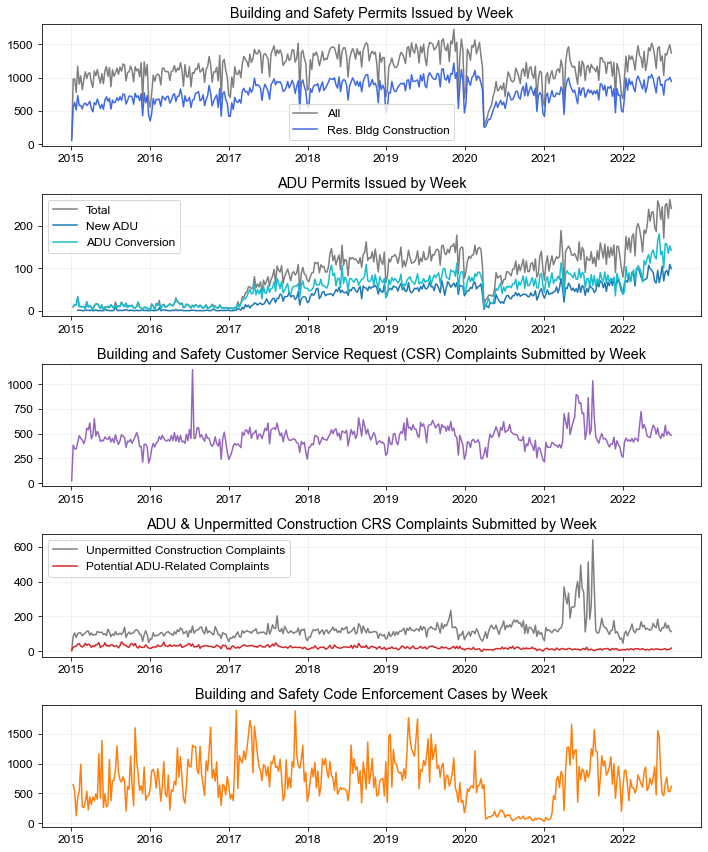

In [469]:
# Plot weekly count of permits, complaints, and enforcement cases
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10,12), sharex=True)
plot_weekly(permits_block_groups, 'issue_date', 'permit_nbr', 'Permits Issued', axs[0], 'tab:gray', 'All')

plot_weekly(permits_block_groups.query('residential_construction_permit == 1'), 
            'issue_date', 'permit_nbr', 
            'Building and Safety Permits Issued', axs[0], 'royalblue', 'Res. Bldg Construction'
            )

plot_weekly(permits_block_groups.query('adu_permit == 1'), 
            'issue_date', 'permit_nbr', 'ADU Permits Issued', axs[1], 'tab:grey', 'Total')

plot_weekly(permits_block_groups.query('adu_permit == 1 & new_adu_construction == 1'), 
            'issue_date', 'permit_nbr', 'ADU-Related Permits Issued', axs[1], 'tab:blue', 'New ADU')

plot_weekly(permits_block_groups.query('adu_permit == 1 & conversion_to_adu == 1'), 
            'issue_date', 'permit_nbr', 'ADU Permits Issued', axs[1], 'tab:cyan', 'ADU Conversion')

plot_weekly(complaints_block_groups, 
            'date_received', 'csr_number', 
            'Building and Safety Customer Service Request (CSR) Complaints Submitted', axs[2], 'tab:purple')

plot_weekly(complaints_block_groups.query('unpermitted_construction_complaint > 0'), 
            'date_received', 'csr_number', 'ADU & Unpermitted Construction CRS Complaints Submitted',
            axs[3], 'tab:gray', 'Unpermitted Construction Complaints')

plot_weekly(complaints_block_groups.query('possible_adu_complaint > 0'), 
            'date_received', 'csr_number', 'ADU & Unpermitted Construction CRS Complaints Submitted', 
            axs[3], 'tab:red', 'Potential ADU-Related Complaints')

plot_weekly(enforcement_block_groups, 'date_case_gen', 'case_number', 
            'Building and Safety Code Enforcement Cases', axs[4], 'tab:orange')

plt.tight_layout()

Next, we plot cumulative permits, complaints, and enforcement cases over time by neighborhood

**Permit Issuance:**

There is a large gulf between the neighborhoods with the most residential permits and the least. The gap is larger when comparing ADU permits, though the rate of ADU permits has increased since the pandemic in many neighborhoods. 


**Complaints:**

Most neighborhoods have a relatively steady rate of complaint submission over time, but a few have noticeable spikes in early 2021 after the pandemic (Sherman Oaks and Encino, for example). The incidence of has been decreasing over time since 2015 in most neighborhoods, but complaints about unpermitted construction spiked significantly in 2021.

**Code Enforcement Cases:**

The number of cumulative enforcement cases by neighborhood seems to follow a step-fuction over time, suggesting the city schedules and handles many cases in a neighborhood at a single time and then goes through neighborhoods sequentially with some amount of time in between visits.

In [470]:
# Plotting function to show cumulative growth in permits, enforcement, and complaints
def plot_cumulative_by_community(df, datecol, uniqueid, measurement, axs):
    by_day_COMM = df.groupby([datecol, 'COMM'])[uniqueid].count().reset_index()
    by_day_COMM['cumulative'] = by_day_COMM.groupby(['COMM'])[uniqueid].cumsum()

    order = list(by_day_COMM.groupby('COMM')['cumulative'].max().sort_values(ascending=False).index)
    by_day_COMM['COMM'] = pd.Categorical(by_day_COMM['COMM'], 
                        categories=order,
                        ordered=True)

    sns.lineplot(
        data=by_day_COMM[by_day_COMM['COMM'].isin(order[0:10])],
        x=datecol,
        y='cumulative',
        hue='COMM',
        ax=axs[0],
        palette='tab10'
    )
    sns.lineplot(
        data=by_day_COMM[~by_day_COMM['COMM'].isin(order[0:10])],
        x=datecol,
        y='cumulative',
        hue='COMM',
        ax=axs[1],
        legend=False
    )
    axs[0].xaxis.set_tick_params(labelbottom=True)
    axs[1].xaxis.set_tick_params(labelbottom=True)
    axs[0].legend(order[0:10])
    axs[0].set_xlabel(None)
    axs[1].set_xlabel(None)
    axs[0].set_ylabel(None)
    axs[1].set_ylabel(None)
    axs[0].set_title('Cumulative ' + measurement + ': Top 10 Neighborhoods')
    axs[1].set_title('All Other Neighborhoods')
    axs[0].grid(alpha=0.2)
    axs[1].grid(alpha=0.2)
    plt.tight_layout()

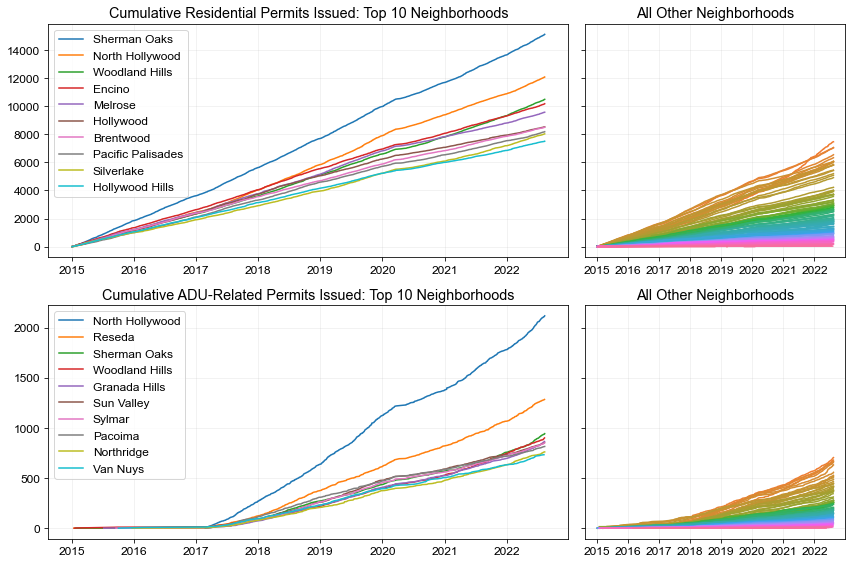

In [471]:
# Permit Issuance over time by neighborhood 
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey='row', 
                        sharex=True, gridspec_kw={'width_ratios': [2, 1]})

plot_cumulative_by_community(permits_block_groups.query('residential_permit == 1'), 
                             'issue_date', 'permit_nbr', 'Residential Permits Issued', axs[0])

plot_cumulative_by_community(permits_block_groups.query('adu_permit == 1'),
                             'issue_date', 'permit_nbr', 'ADU-Related Permits Issued', axs[1])

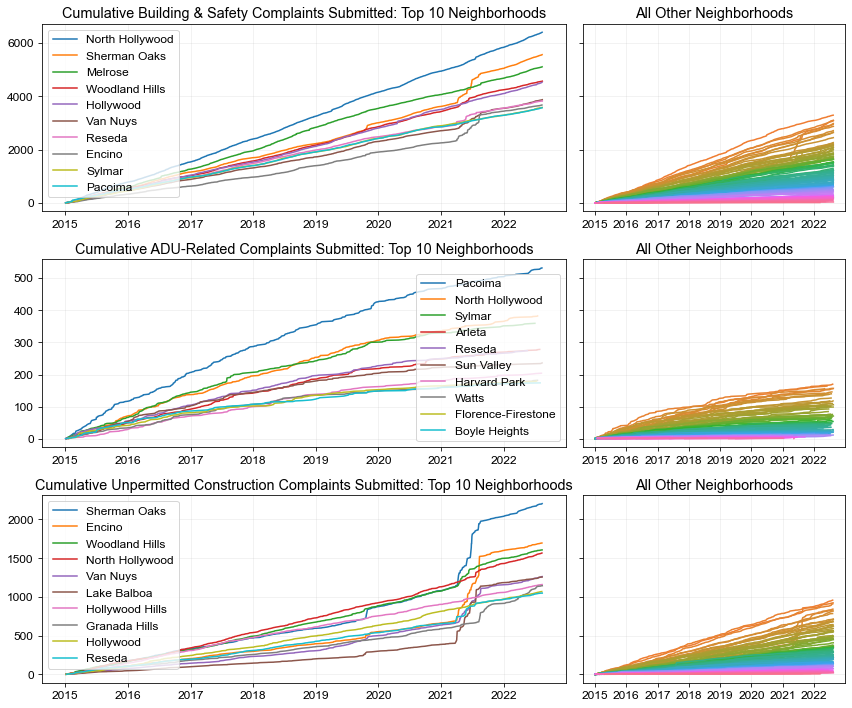

In [472]:
# Building & Safety complaints submitted over time by neighborhood
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,10), 
                        sharey='row', sharex=True, gridspec_kw={'width_ratios': [2, 1]})

plot_cumulative_by_community(complaints_block_groups, 'date_received', 'csr_number', 
                             'Building & Safety Complaints Submitted', axs[0])

plot_cumulative_by_community(complaints_block_groups.query('possible_adu_complaint > 0'), 
                             'date_received', 'csr_number', 'ADU-Related Complaints Submitted', axs[1])

plot_cumulative_by_community(
    complaints_block_groups.query('unpermitted_construction_complaint > 0'), 
    'date_received', 'csr_number', 'Unpermitted Construction Complaints Submitted', axs[2]
    )

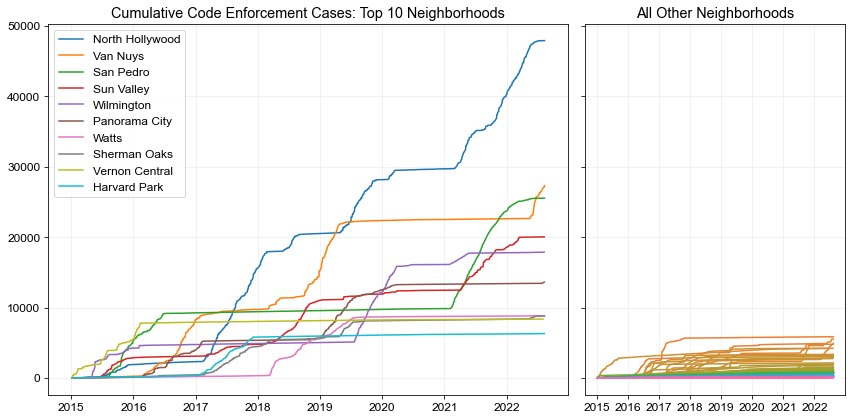

In [473]:
# Building & Safety code enforcement cases over time by neighborhood
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), 
                       sharey='row', sharex=True, gridspec_kw={'width_ratios': [2, 1]})
plot_cumulative_by_community(
    enforcement_block_groups, 'date_case_gen', 'case_number', 'Code Enforcement Cases', ax
)

#### Part V b) Geographic Analysis

In [474]:
# Prep data to join to block group shapefile for mapping
for df in [complaints_block_groups, enforcement_block_groups, permits_block_groups]:
    df['BG20'] = df['tract'].astype(str) + df['block_group'].astype(str)
    df['CT20'] = df['tract'].astype(str)

# Merge to shapefile
complaints_block_groups_shp = pd.merge(df_la_shp_bg, complaints_block_groups, on=['BG20', 'CT20'], how='left')
enforcement_block_groups_shp = pd.merge(df_la_shp_bg, enforcement_block_groups, on=['BG20', 'CT20'], how='left')
permits_block_groups_shp = pd.merge(df_la_shp_bg, permits_block_groups, on=['BG20', 'CT20'], how='left')

# Function to aggregate metrics for mapping
def bg20_summary(df, df_shp, uniqueid, column_aggregations):
    
    metric_cols = [
        'total_population',
        'total_white_population',	
        'total_households',	
        'total_housing_units',	
        'median_household_value',	
        'tract_gini_index',	
        'median_household_income',	
        'owner_occupied_units',
        'percent_white',
        'percent_owner_occupied',
        'low_income_hh',
        'poverty_hh'
    ]

    df_summary = pd.merge(
        df_shp[['BG20','geometry_x']].drop_duplicates(), 
        df.groupby('BG20').agg(column_aggregations).reset_index(),
        how='left', 
        on='BG20'
    ).merge(
        df_shp.groupby('BG20')[metric_cols].max().reset_index(),
        how='left',
        on='BG20'
    )

    df_summary['per_100k'] = df_summary[uniqueid] / df_summary['total_population'] * 100000
    df_summary['per_household'] = df_summary[uniqueid] / df_summary['total_households']

    df_summary = df_summary.replace([np.inf, -np.inf], 0)

    df_summary = gpd.GeoDataFrame(df_summary, geometry='geometry_x')

    return df_summary

In [475]:
# Create block group aggregation tables
permits_BG_summary = bg20_summary(
    permits_block_groups,
    permits_block_groups_shp, 
    'permit_nbr', 
    {
        'permit_nbr':'count', 
        'adu_permit':'sum', 
        'new_adu_construction':'sum', 
        'conversion_to_adu':'sum', 
        'residential_permit':'sum', 'residential_construction_permit':'sum', 'valuation':'mean'
    }
)

permits_BG_summary = permits_BG_summary[
    (permits_BG_summary['total_population'] > 0) & (permits_BG_summary['total_households'] > 0)]

permits_BG_summary['permits_per_100k'] = permits_BG_summary['permit_nbr'] / 
                                                permits_BG_summary['total_population'] * 100000

permits_BG_summary['permits_per_household'] = permits_BG_summary['permit_nbr'] / 
                                                permits_BG_summary['total_households']

permits_BG_summary['ADU_permits_per_100k'] = permits_BG_summary['adu_permit'] / 
                                                permits_BG_summary['total_population'] * 100000

permits_BG_summary['ADU_permits_per_household'] = permits_BG_summary['adu_permit'] / 
                                                    permits_BG_summary['total_households']

permits_BG_summary['residential_permits_per_100k'] = permits_BG_summary['residential_permit'] / 
                                                        permits_BG_summary['total_population'] * 100000

permits_BG_summary['residential_permit_per_household'] = permits_BG_summary['residential_permit'] / 
                                                            permits_BG_summary['total_households']

permits_BG_summary['residential_construction_permits_per_100k'] = permits_BG_summary[
        'residential_construction_permit'] / permits_BG_summary['total_population'] * 100000

permits_BG_summary['residential_construction_permit_per_household'] = permits_BG_summary[
        'residential_construction_permit'] / permits_BG_summary['total_households']

permits_BG_summary.fillna(0, inplace=True)
permits_BG_summary = permits_BG_summary.replace([np.inf, -np.inf], 0)

# Create block group summary for mapping of complaints
complaints_BG_summary = bg20_summary(
    complaints_block_groups,
    complaints_block_groups_shp, 
    'csr_number', 
    {'csr_number':'count', 'csr_priority':'mean', 'possible_adu_complaint':'sum', 'case_flag':'mean'}
)
complaints_BG_summary = complaints_BG_summary[
        (complaints_BG_summary['total_population'] > 0) & (complaints_BG_summary['total_households'] > 0)
    ]

complaints_BG_summary['ADU_complaints_per_100k'] = complaints_BG_summary['possible_adu_complaint'] / 
                                                            complaints_BG_summary['total_population'] * 100000

complaints_BG_summary['ADU_complaints_per_household'] = complaints_BG_summary['possible_adu_complaint'] / 
                                                            complaints_BG_summary['total_households']

complaints_BG_summary.fillna(0, inplace=True)

# Create block group summary for mapping of enforcement
enforcement_BG_summary = bg20_summary(
    enforcement_block_groups,
    enforcement_block_groups_shp, 
    'case_number', 
    {'case_number':'count'}
)


The geographic distribution of ADU-related permits is very different than that of residential construction permits writ large. Despite ADU permits being common in the southern areas of LA, most of the ADU-related CSR complaints are clustered in the northern regions.

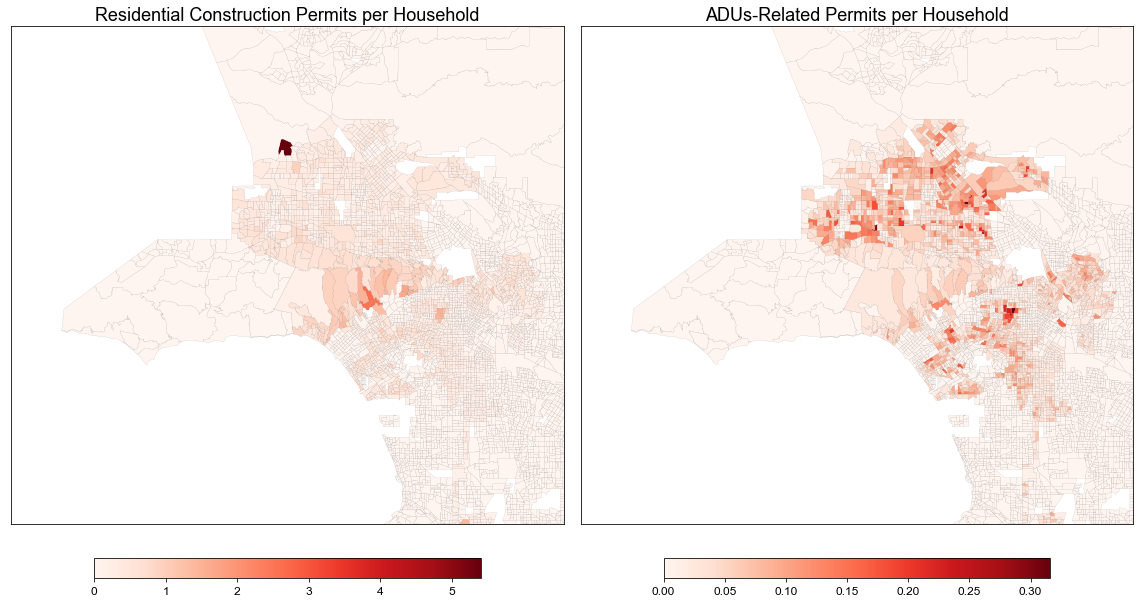

In [476]:
# Map of permits by neighborhood
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,10))
permits_BG_summary.query('total_households > 20').plot(
    column='residential_construction_permit_per_household',
    cmap='Reds',
    linewidth=0.05,
    edgecolor='black',    
    legend=True,
    legend_kwds={'shrink': 0.7, 'location':'bottom', 'pad':0.05},
    ax=axs[0]
    )
permits_BG_summary.query('total_households > 20').plot(
    column='ADU_permits_per_household',
    cmap='Reds',
    linewidth=0.05,
    edgecolor='black',
    legend=True,
    legend_kwds={'shrink': 0.7, 'location':'bottom', 'pad':0.05},
    ax=axs[1]
    )    
axs[0].set_title('Residential Construction Permits per Household', fontsize=18)       
axs[1].set_title('ADUs-Related Permits per Household', fontsize=18)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(4000000, 4090000)
    ax.set_xlim(-13250000, -13150000)
plt.tight_layout()

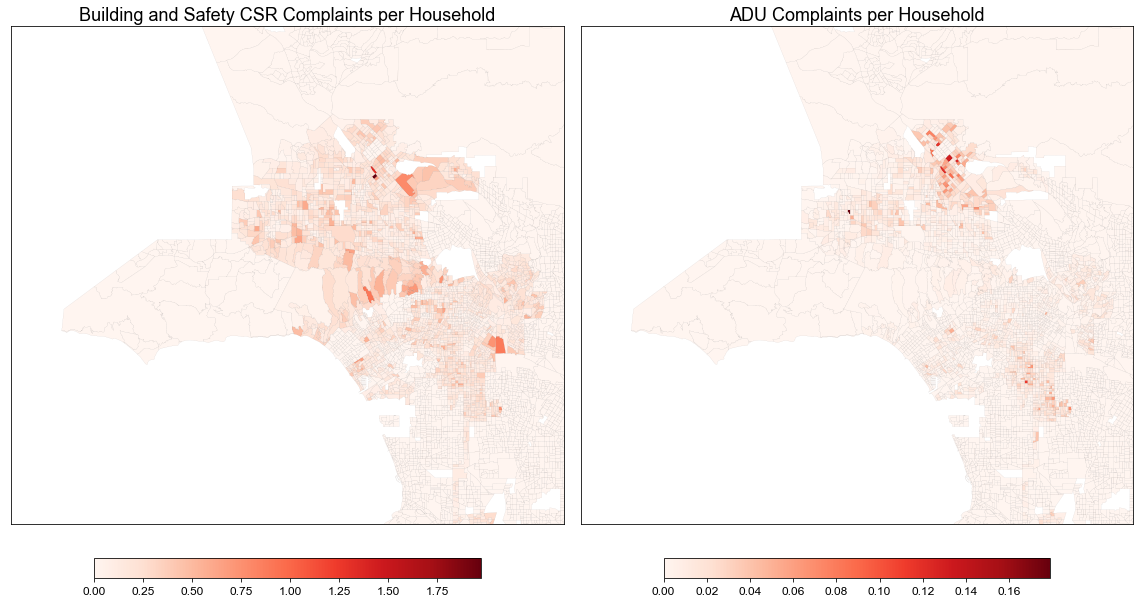

In [477]:
# Map of complaints by neighborhood
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,10))
complaints_BG_summary.query('total_households > 20').plot(
    column='per_household',
    cmap='Reds',
    linewidth=0.03,
    edgecolor='black',
    legend=True,
    legend_kwds={'shrink': 0.7, 'location':'bottom', 'pad':0.05},
    ax=axs[0]
    )
complaints_BG_summary.query('total_households > 20').plot(
    column='ADU_complaints_per_household',
    cmap='Reds',
    linewidth=0.03,
    edgecolor='black',
    legend=True,
    legend_kwds={'shrink': 0.7, 'location':'bottom', 'pad':0.05},
    ax=axs[1]
    )   
axs[0].set_title('Building and Safety CSR Complaints per Household', fontsize=18)       
axs[1].set_title('ADU Complaints per Household', fontsize=18)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(4000000, 4090000)
    ax.set_xlim(-13250000, -13150000)
plt.tight_layout()

(-13250000.0, -13150000.0)

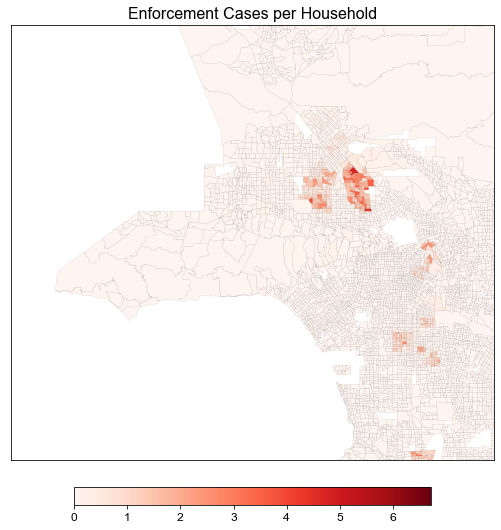

In [478]:
# Map of enforcement cases by neighborhood
fig, axs = plt.subplots(figsize=(16,10))
enforcement_BG_summary.query('total_households > 20').plot(
    column='per_household',
    cmap='Reds',
    linewidth=0.05,
    edgecolor='black',
    legend=True,
    legend_kwds={'shrink': 0.4, 'location':'bottom', 'pad':0.05},
    ax=axs
    )
axs.set_title('Enforcement Cases per Household', fontsize=16)       
axs.set_xticks([])
axs.set_yticks([])
axs.set_ylim(4000000, 4090000)
axs.set_xlim(-13250000, -13150000)
 

#### Part V c) Analysis of Permits by Economic and Demographic Factors

An area having a higher proportion of low-income (less than $50k) households is associated with there being fewer residential and ADU permits issued. Whiter neighborhoods tend to have more permits of both types issued. 

Among other demographic & economic factors, owner occupancy rates, median household value, median income, and income inequality are all associated with more permits. It is worth noting that many of these variables are highly correlated with each other.


#### Residential Permits per Household

In [479]:
# Regress permits per hh on economic and demographic variables
reg1 = sm.ols(
    'residential_permit_per_household ~ low_income_hh', 
    data=permits_BG_summary.query('per_household > 0')
).fit(cov_type='HC1') 

reg2 = sm.ols(
    'residential_permit_per_household ~ percent_white', 
    data=permits_BG_summary.query('per_household > 0')
).fit(cov_type='HC1')

reg3 = sm.ols('residential_permit_per_household ~ low_income_hh + percent_white', data=permits_BG_summary\
              .query('per_household > 0'))\
              .fit(cov_type='HC1')

reg4 = sm.ols('ADU_permits_per_household ~ low_income_hh', data=permits_BG_summary.query('per_household > 0'))\
    .fit(cov_type='HC1') 

reg5 = sm.ols('ADU_permits_per_household ~ percent_white', data=permits_BG_summary.query('per_household > 0'))\
    .fit(cov_type='HC1')

reg6 = sm.ols('ADU_permits_per_household ~ low_income_hh + percent_white', data=permits_BG_summary\
              .query('per_household > 0'))\
              .fit(cov_type='HC1')

stargazer = Stargazer([reg1,reg2,reg3,reg4,reg5,reg6])
stargazer.custom_columns(
    ['Res. Permits/HH', 'Res. Permits/HH', 'Res. Permits/HH', 
     'ADU Permits/HH', 'ADU Permits/HH', 'ADU Permits/HH'], 
    [1,1,1,1,1,1]
)
stargazer.title('Residential Permits Issued per Household Regressed on Economic & Demographic Variables')
stargazer.significant_digits(4)
HTML(stargazer.render_html())

#### Residential Permits per 100k

In [480]:
# Regress permits per 100k on economic and demographic variables
reg1 = sm.ols(
    'residential_permits_per_100k ~ low_income_hh', 
    data=permits_BG_summary.query('per_household > 0')
).fit(cov_type='HC1') 

reg2 = sm.ols(
    'residential_permits_per_100k ~ percent_white', 
    data=permits_BG_summary.query('per_household > 0')
).fit(cov_type='HC1')

reg3 = sm.ols('residential_permits_per_100k ~ low_income_hh + percent_white', data=permits_BG_summary\
              .query('per_household > 0'))\
              .fit(cov_type='HC1')

reg4 = sm.ols('ADU_permits_per_100k ~ low_income_hh', data=permits_BG_summary.query('per_household > 0'))\
    .fit(cov_type='HC1') 

reg5 = sm.ols('ADU_permits_per_100k ~ percent_white', data=permits_BG_summary.query('per_household > 0'))\
    .fit(cov_type='HC1')

reg6 = sm.ols('ADU_permits_per_100k ~ low_income_hh + percent_white', data=permits_BG_summary\
              .query('per_household > 0'))\
              .fit(cov_type='HC1')

stargazer = Stargazer([reg1,reg2,reg3,reg4,reg5,reg6])
stargazer.custom_columns(
    ['Res. Permits/100k', 'Res. Permits/100k', 'Res. Permits/100k', 
     'ADU Permits/100k', 'ADU Permits/100k', 'ADU Permits/100k'],
    [1,1,1,1,1,1]
)
stargazer.title('Residential Permits Issued per 100k Residents Regressed on Economic & Demographic Variables')
stargazer.significant_digits(4)
HTML(stargazer.render_html())

In [481]:
# Function to plot multiple jointplots on a grid
def jointplot_grid(data, conditions, x, y, xlims, ylims, colors, titles):

    # pw.overwrite_axisgrid() 
    
    gridlist = []
    
    for i in range(12):
        
        if i % 2 == 0:            
            yval = y[0]
            ylimval = ylims[0]
        else:            
            yval = y[1]
            ylimval = ylims[1]
        
        g = sns.jointplot(
            data=data.query(conditions[int(np.floor(i / 2))]),
            x=x[int(np.floor(i / 2))],
            y=yval,
            kind='reg',
            scatter_kws={'alpha':0.1},            
            color=colors[int(np.floor(i / 2))],
            xlim=xlims[int(np.floor(i / 2))],            
            ylim=ylimval
        )       
        g = pw.load_seaborngrid(g)                      
        g.set_suptitle(titles[i])
        gridlist.append(g)
    
    row1 = gridlist[0] | gridlist[1] | gridlist[2] | gridlist[3]
    row2 = gridlist[4] | gridlist[5] | gridlist[6] | gridlist[7]
    row3 = gridlist[8] | gridlist[9] | gridlist[10] | gridlist[11]
    
    return (row1 / row2 / row3).savefig()

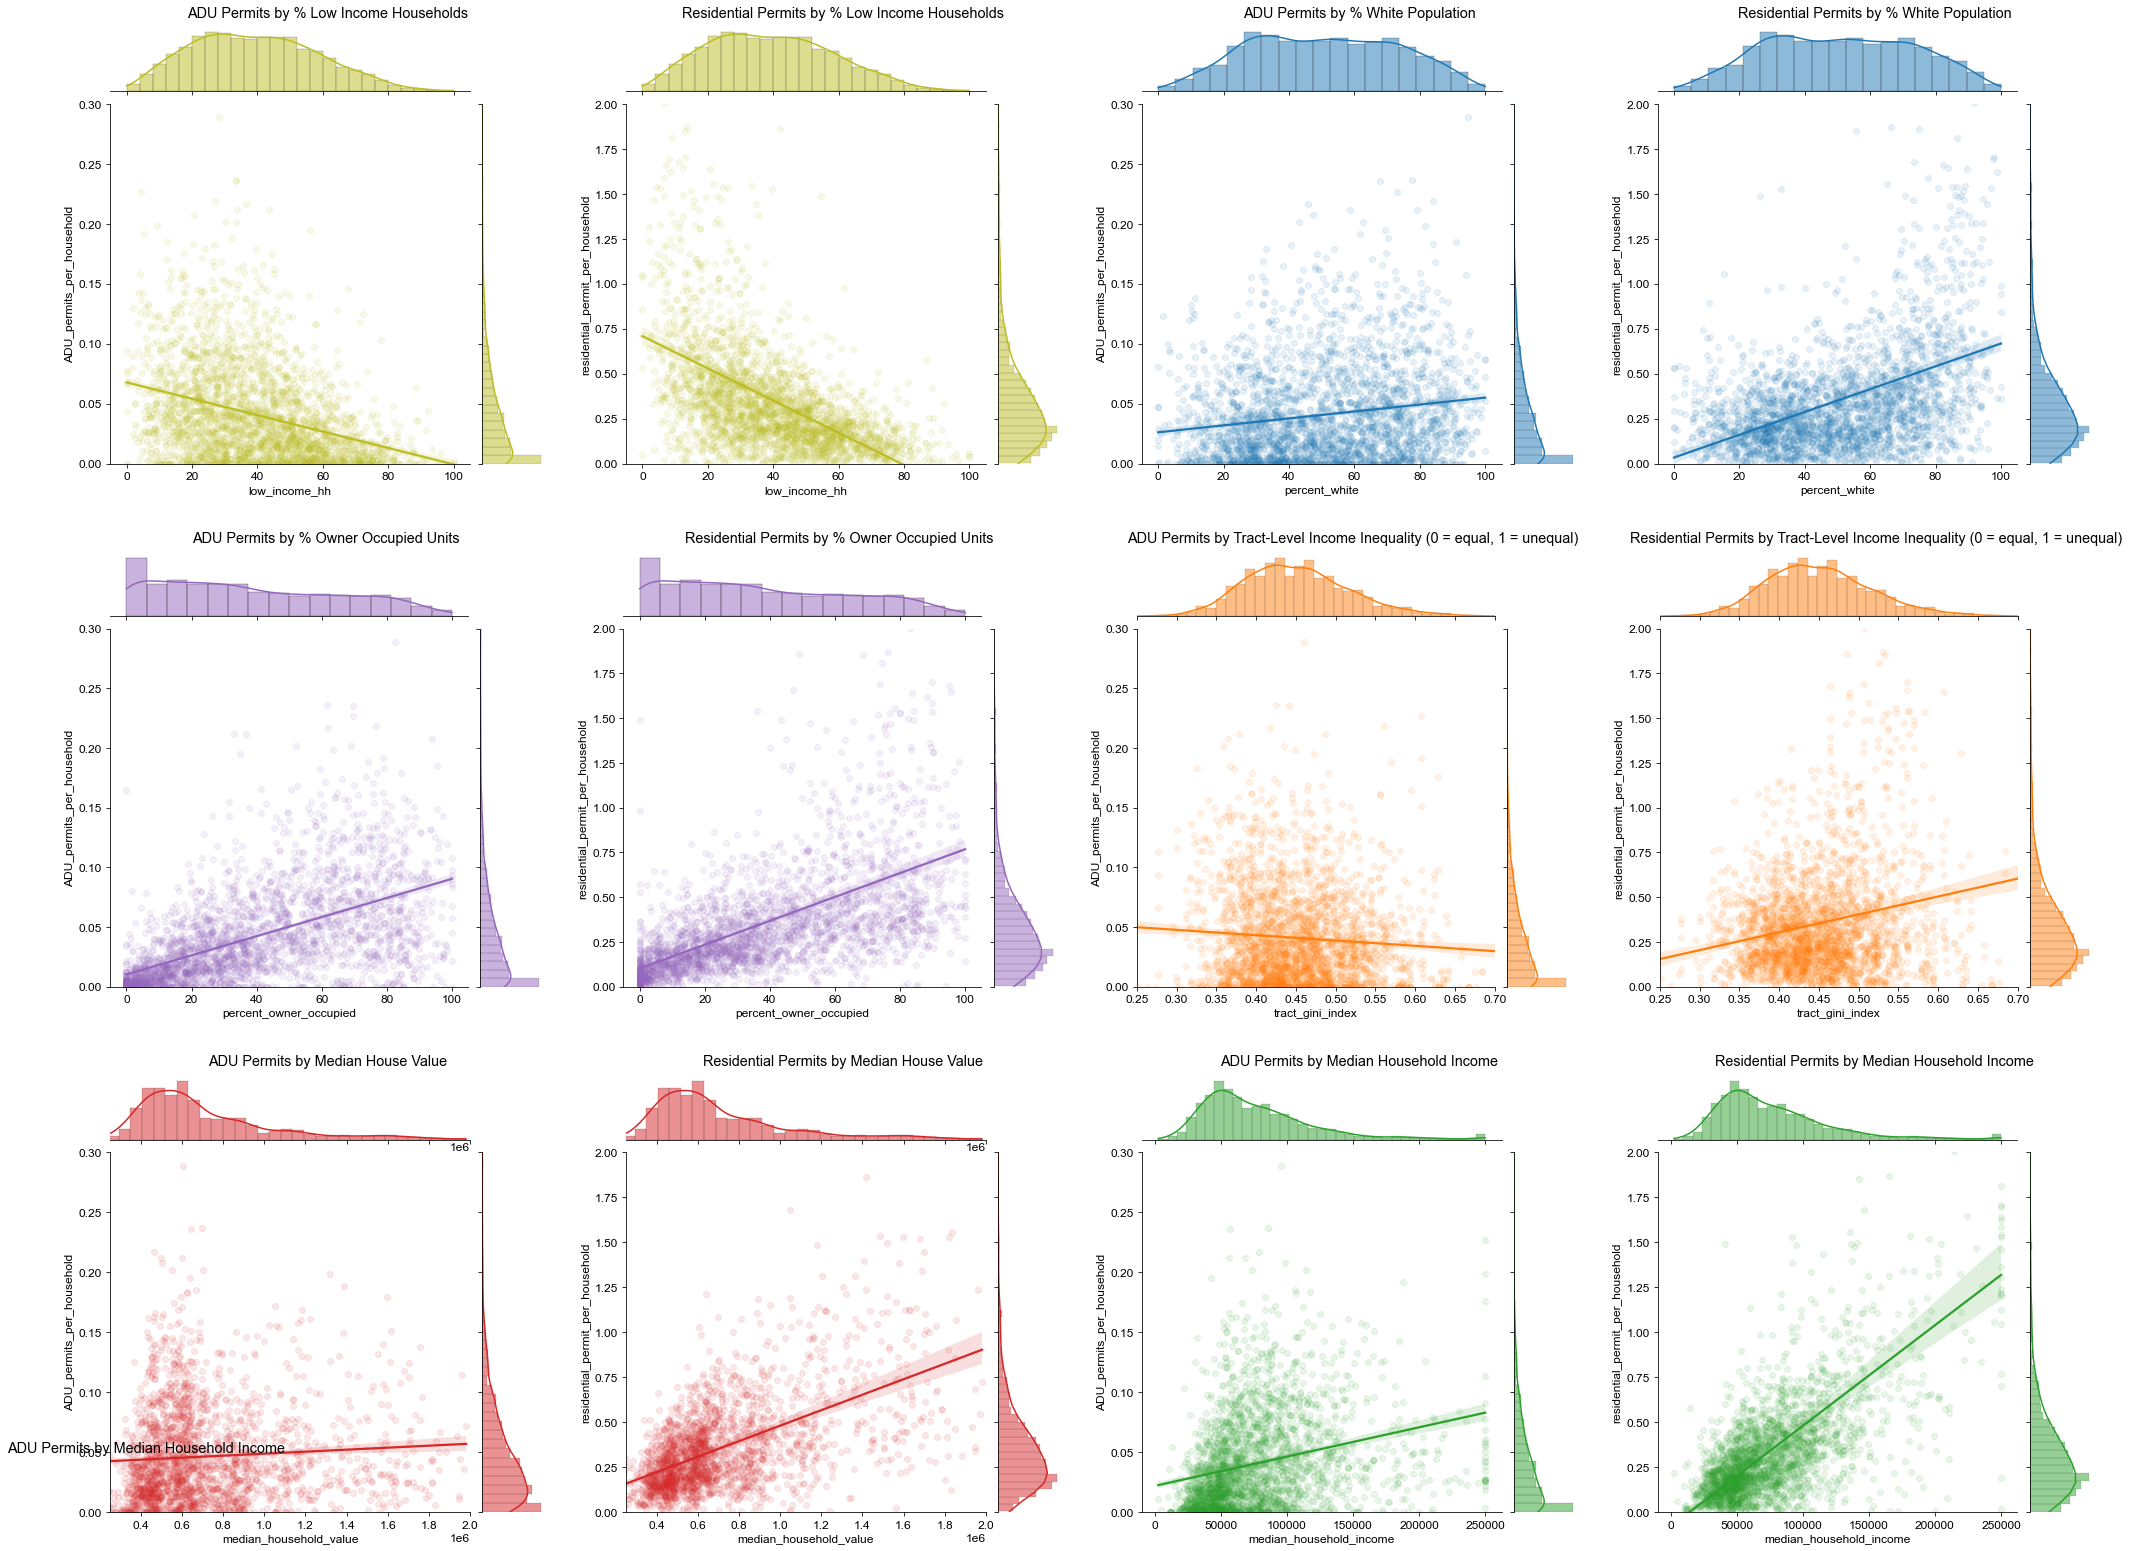

In [482]:
# Create jointplot grid of economic and demographic variables
condition_list = [
    'residential_permit_per_household > 0', 
    'residential_permit_per_household > 0', 
    'residential_permit_per_household > 0', 
    'residential_permit_per_household > 0 and tract_gini_index > 0', 
    'residential_permit_per_household > 0 and median_household_value > 0 and median_household_value < 2000000', 
    'residential_permit_per_household > 0 and median_household_income> 0',
]   
xs = ['low_income_hh',
      'percent_white',
      'percent_owner_occupied',
      'tract_gini_index',
      'median_household_value',
      'median_household_income']
ys = ['ADU_permits_per_household','residential_permit_per_household']
xlims = [None, None, None,(0.25,0.7),(250000,2000000), None, None]
ylims = [(0,0.3), (0,2)]
colors = ['tab:olive','tab:blue','tab:purple','tab:orange','tab:red','tab:green']
titles = [
    'ADU Permits by % Low Income Households',
    'Residential Permits by % Low Income Households',
    'ADU Permits by % White Population',
    'Residential Permits by % White Population',
    'ADU Permits by % Owner Occupied Units',
    'Residential Permits by % Owner Occupied Units',
    'ADU Permits by Tract-Level Income Inequality (0 = equal, 1 = unequal)',
    'Residential Permits by Tract-Level Income Inequality (0 = equal, 1 = unequal)', 
    'ADU Permits by Median House Value',
    'Residential Permits by Median House Value', 
    'ADU Permits by Median Household Income', 
    'Residential Permits by Median Household Income'
]

jointplot_grid(permits_BG_summary, condition_list, xs, ys, xlims, ylims, colors, titles)


#### Part V d) Analysis of Complaints by Economic and Demographic Factors

A neighborhood having a higher proportion of low-income (less than $50k) households tends to have fewer complaints and ADU complaints filed with the Department of Building & Safety. Whiter neighborhoods tend to have fewer ADU complaints. 

One interpretation of these results is that code enforcement driven by citizen complaints would direct city attention disprportionately to high-income neighborhoods, leaving their low-income counterparts underresourced and vulnerable to health & safety issues. It should ne noted, however, that the number of complaints is highly correlated with the amount of construction (indicated in our data by permit issuance). A later analysis will regress complaints on these same factors controlling for the amount of construction. 

#### Complaints per Household

In [483]:
# Regress complaints per household on economic and demographic variables
reg1 = sm.ols('per_household ~ low_income_hh', data=complaints_BG_summary.query('per_household > 0'))\
    .fit(cov_type='HC1') 

reg2 = sm.ols('per_household ~ percent_white', data=complaints_BG_summary.query('per_household > 0'))\
    .fit(cov_type='HC1')

reg3 = sm.ols('per_household ~ low_income_hh + percent_white', 
              data=complaints_BG_summary.query('per_household > 0')).fit(cov_type='HC1')

reg4 = sm.ols('ADU_complaints_per_household ~ low_income_hh', 
              data=complaints_BG_summary.query('per_household > 0')).fit(cov_type='HC1')

reg5 = sm.ols('ADU_complaints_per_household ~ percent_white', 
              data=complaints_BG_summary.query('per_household > 0')).fit(cov_type='HC1')

reg6 = sm.ols('ADU_complaints_per_household ~ low_income_hh + percent_white ', data=complaints_BG_summary\
              .query('per_household > 0'))\
              .fit(cov_type='HC1')

stargazer = Stargazer([reg1,reg2,reg3,reg4,reg5,reg6])
stargazer.custom_columns(
    ['Complaints/HH', 'Complaints/HH', 'Complaints/HH', 'ADU Complaints/HH', 
     'ADU Complaints/HH', 'ADU Complaints/HH'], 
    [1,1,1,1,1,1]
)
stargazer.title('Complaints per Household Regressed on Economic & Demographic Variables')
stargazer.significant_digits(4)
HTML(stargazer.render_html())

In [484]:
# Regress complaints per 100k on economic and demographic variables
reg1 = sm.ols('per_100k ~ low_income_hh', data=complaints_BG_summary.query('per_100k > 0'))\
    .fit(cov_type='HC1') 

reg2 = sm.ols('per_100k ~ percent_white', data=complaints_BG_summary.query('per_100k > 0'))\
    .fit(cov_type='HC1')

reg3 = sm.ols('per_100k ~ low_income_hh + percent_white', data=complaints_BG_summary.query('per_100k > 0'))\
    .fit(cov_type='HC1')

reg4 = sm.ols('ADU_complaints_per_100k ~ low_income_hh', data=complaints_BG_summary.query('per_100k > 0'))\
    .fit(cov_type='HC1')

reg5 = sm.ols('ADU_complaints_per_100k ~ percent_white', data=complaints_BG_summary.query('per_100k > 0'))\
    .fit(cov_type='HC1')

reg6 = sm.ols('ADU_complaints_per_100k ~ low_income_hh + percent_white ', data=complaints_BG_summary\
              .query('per_100k > 0'))\
              .fit(cov_type='HC1')

stargazer = Stargazer([reg1,reg2,reg3,reg4,reg5,reg6])
stargazer.custom_columns(
    ['Complaints/100k', 'Complaints/100k', 'Complaints/100k', 
     'ADU Complaints/100k', 'ADU Complaints/100k', 'ADU Complaints/100k'], 
     [1,1,1,1,1,1]
)
stargazer.title('Complaints per 100k Residents Regressed on Economic & Demographic Variables')
stargazer.significant_digits(4)
HTML(stargazer.render_html())

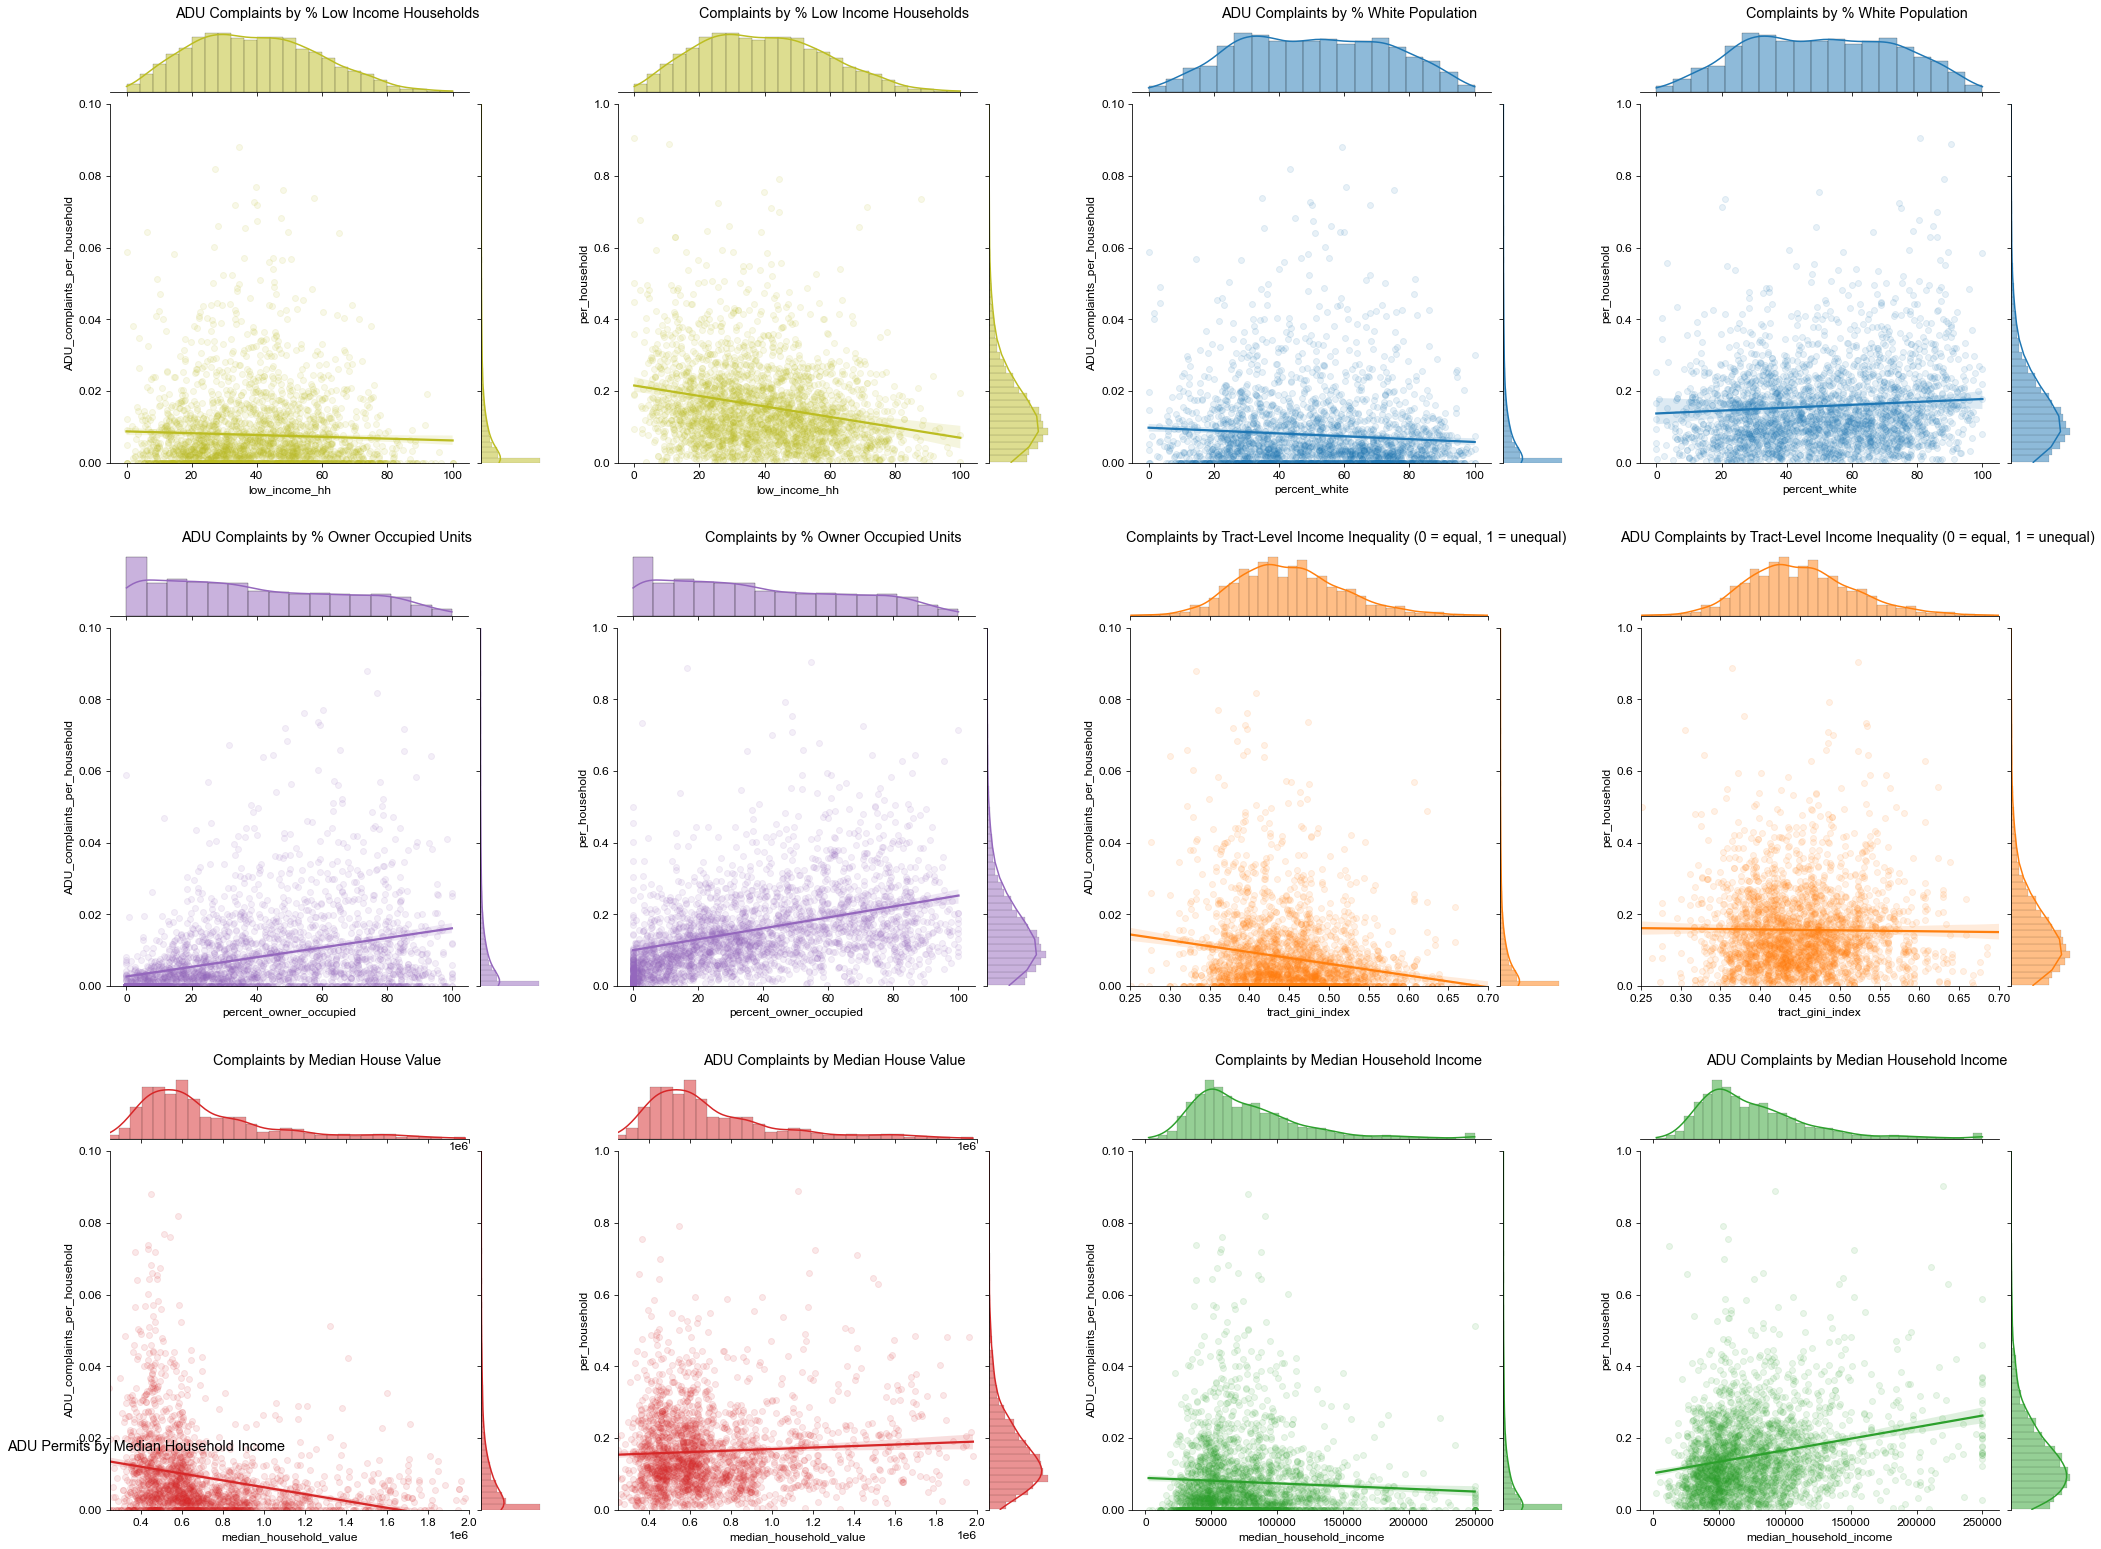

In [485]:
# Create jointplot grid of economic and demographic variables
condition_list = [
    'per_household > 0', 'per_household > 0', 'per_household > 0', 
    'per_household > 0 and tract_gini_index > 0', 
    'per_household > 0 and median_household_value > 0 and median_household_value < 2000000', 
    'per_household > 0 and median_household_income> 0',
]   
ys = ['ADU_complaints_per_household','per_household']
ylims = [(0,0.1), (0,1)]
titles = [
    'ADU Complaints by % Low Income Households',
    'Complaints by % Low Income Households',
    'ADU Complaints by % White Population',
    'Complaints by % White Population',
    'ADU Complaints by % Owner Occupied Units',
    'Complaints by % Owner Occupied Units',
    'Complaints by Tract-Level Income Inequality (0 = equal, 1 = unequal)', 
    'ADU Complaints by Tract-Level Income Inequality (0 = equal, 1 = unequal)',
    'Complaints by Median House Value', 
    'ADU Complaints by Median House Value', 
    'Complaints by Median Household Income', 
    'ADU Complaints by Median Household Income'
]

jointplot_grid(complaints_BG_summary, condition_list, xs, ys, xlims, ylims, colors, titles)

#### Complaints -> Code Enforcement Cases

CSR priority, which is a score given to a customer service request based on the request type, is not correlated with a neighborhood's whiteness or income. Lower income and less white neighborhoods tend to have a greater proportion of complaints converted into code enforcement cases. These findings 

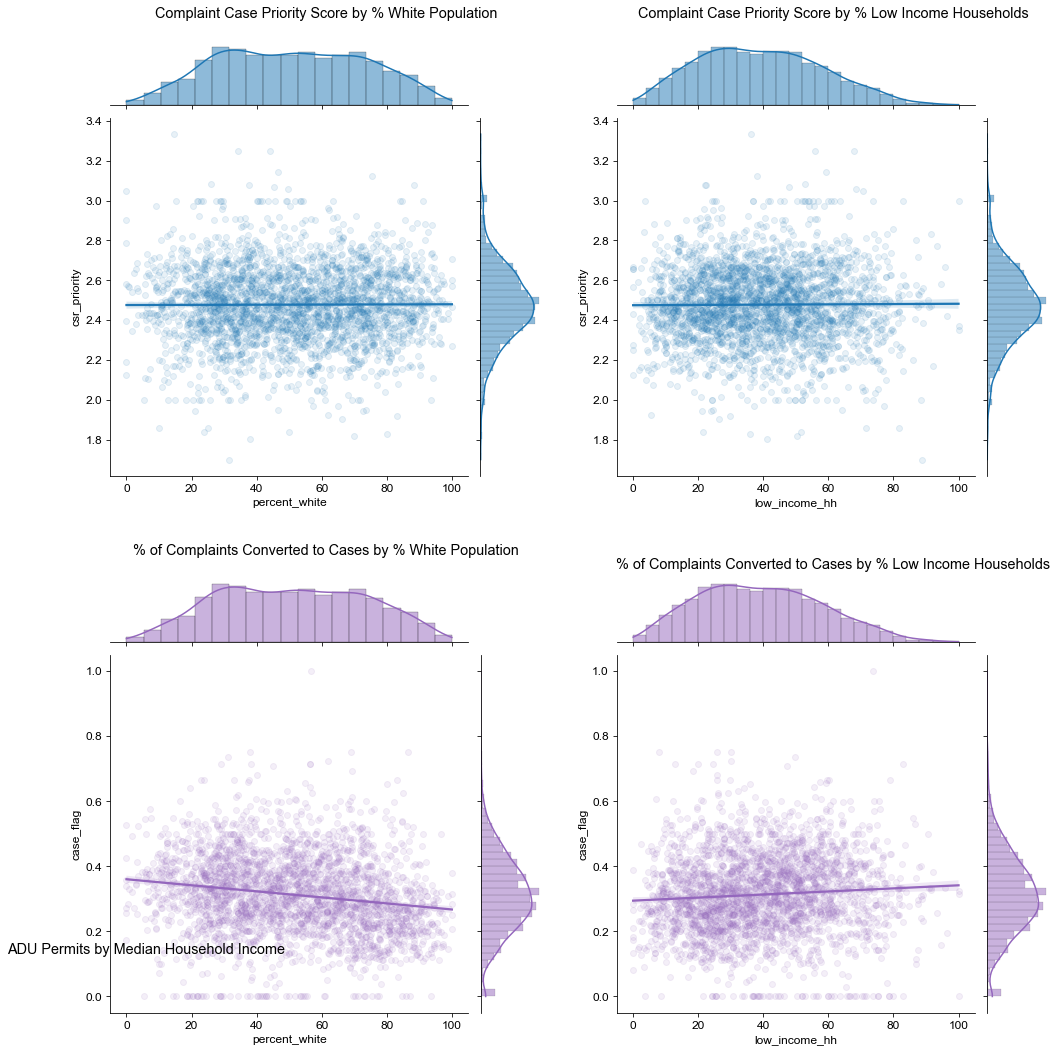

In [494]:
# Jointplot grid regressing CSR priority and case rate on demo and econ variables
g1 = sns.jointplot(
        data=complaints_BG_summary.query('csr_priority > 0'),
        x='percent_white',
        y='csr_priority',
        kind='reg',
        scatter_kws={'alpha':0.1},
        color='tab:blue'
    )
g1 = pw.load_seaborngrid(g1)    
g1.set_suptitle('Complaint Case Priority Score by % White Population', y=1.03)   

g2 = sns.jointplot(
        data=complaints_BG_summary.query('csr_priority > 0'),
        x='low_income_hh',
        y='csr_priority',
        kind='reg',
        scatter_kws={'alpha':0.1},
        color='tab:blue'
    )
g2 = pw.load_seaborngrid(g2)    
g2.set_suptitle('Complaint Case Priority Score by % Low Income Households', y=1.03)   

g3 = sns.jointplot(
        data=complaints_BG_summary.query('csr_priority > 0'),
        x='percent_white',
        y='case_flag',
        kind='reg',
        scatter_kws={'alpha':0.1},
        color='tab:purple'
    )    
g3 = pw.load_seaborngrid(g3)    
g3.set_suptitle('% of Complaints Converted to Cases by % White Population', y=1.03)   


g4 = sns.jointplot(
        data=complaints_BG_summary.query('csr_priority > 0'),
        x='low_income_hh',
        y='case_flag',
        kind='reg',
        scatter_kws={'alpha':0.1}  ,
        color='tab:purple'      
    )
g4 = pw.load_seaborngrid(g4)    
g4.set_suptitle('% of Complaints Converted to Cases by % Low Income Households')

row1 = g1 | g2 
row2 = g3 | g4 

(row1 / row2).savefig()

#### Accounting for Correlation Between Number of Complaints & Number of Permits

Given that more complaints are likely to be filed in areas where there is more construction, we run another regression of complaints on economic & demographic factors controlling for the number of residential construction permits per household. Here, we see that the coefficients on neither income nor whiteness are significant for complaints, but the coefficient on percent_white is significant in specifications 4 & 5 which use ADU complaints as the dependent variable. In both cases, the latter of which controls for the prevalence of low income households, a neighborhood being whiter is associated with fewer ADU complaints. 

In [488]:
# Join permits and complaints dataframes to regress controlling for permit count
complaints_permits = complaints_BG_summary.merge(permits_BG_summary, on='BG20', suffixes=['', '_permit'])

r1 = sm.ols(
        'per_household ~ low_income_hh + residential_construction_permit_per_household', 
        data=complaints_permits.query('per_household > 0 ')
    ).fit(cov_type='HC1')
r2 = sm.ols(
        'per_household ~ percent_white + residential_construction_permit_per_household', 
        data=complaints_permits.query('per_household > 0 ')
    ).fit(cov_type='HC1')
r3 = sm.ols(
        'per_household ~ percent_white + low_income_hh + residential_construction_permit_per_household', 
        data=complaints_permits.query('per_household > 0 ')
    ).fit(cov_type='HC1')        
r4 = sm.ols(
        'ADU_complaints_per_household ~ low_income_hh+ residential_construction_permit_per_household', 
        data=complaints_permits.query('per_household > 0 ')
    ).fit(cov_type='HC1')
r5 = sm.ols(
        'ADU_complaints_per_household ~ percent_white + residential_construction_permit_per_household', 
        data=complaints_permits.query('per_household > 0 ')
    ).fit(cov_type='HC1')
r6 = sm.ols(
        'ADU_complaints_per_household ~ percent_white + low_income_hh + residential_construction_permit_per_household', 
        data=complaints_permits.query('per_household > 0 ')
    ).fit(cov_type='HC1')


stargazer = Stargazer([r1,r2,r3,r4,r5,r6])
stargazer.custom_columns(
    ['Complaints/HH', 'Complaints/HH', 'Complaints/HH', 
     'ADU Complaints/HH', 'ADU Complaints/HH', 'ADU Complaints/HH'], 
    [1,1,1,1,1,1]
)
stargazer.title(
    'Complaints per Household Regressed on Economic & Demographic Variables, Controlling for Permit Count'
)
stargazer.significant_digits(4)
HTML(stargazer.render_html())